In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness

In [2]:
# ============Load and Clean Data ============
dataset_dir = r"C:\Users\chenn\OneDrive\Desktop\btp\dataset_btp"
csv_path = os.path.join(dataset_dir, "BTP_1_Dataset.csv")
df = pd.read_csv(csv_path)

df["Power_to_Speed"] = df["Laser_Power"] / df["Scan_Speed"]
df["Energy_Density"] = df["Laser_Power"] / (df["Spot_Diameter"] * df["Scan_Speed"])
df["Flow_to_Cooling"] = df["Material_FlowRate"] / (df["Cooling_Rate"] + 1e-6)
df = df.drop(columns=['Stand_Off', 'Spot_Diameter', 'Material_FlowRate'])
df = pd.get_dummies(df, columns=['Material_Type'], prefix='Material')

numerical_features = ['Laser_Power', 'Scan_Speed', 'Cooling_Rate',
                      'Power_to_Speed', 'Energy_Density', 'Flow_to_Cooling']
categorical_features = [col for col in df.columns if col.startswith('Material_')]
features = numerical_features + categorical_features
targets = ['Aspect_Ratio', 'Dilution_Percent', 'PCE_Percent']

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

IMAGE_SIZE = (224, 224)
def preprocess_image(path):
    full_path = os.path.join(dataset_dir, path) if not os.path.isabs(path) else path
    img = load_img(full_path, target_size=IMAGE_SIZE, color_mode='rgb')  # Force RGB
    img_array = img_to_array(img)
    img_array = resnet_preprocess(img_array)
    return img_array

image_arrays = np.array([preprocess_image(img_path) for img_path in df['Images']], dtype=np.float32)
X_num = df[features].values.astype(np.float32)
Y = df[targets].values.astype(np.float32)

X_num_train, X_num_test, X_img_train, X_img_test, Y_train, Y_test = train_test_split(
    X_num, image_arrays, Y, test_size=0.2, random_state=42
)

In [3]:
# ============ Build ResNet50 Fusion Model ============
base_cnn = ResNet50(include_top=False, weights='imagenet', pooling='avg', input_shape=(224,224,3))
base_cnn.trainable = False  # Freeze weights for small dataset

img_input = Input(shape=(224,224,3), name='image_input')

# -----------------------------
# Data Augmentation Block
# -----------------------------
augmented = RandomFlip("horizontal_and_vertical")(img_input)
# rotate ±20%
augmented = RandomRotation(0.2)(augmented)
# zoom in/out ±20%
augmented = RandomZoom(0.2)(augmented)

# Pass augmented images to ResNet50
img_features = base_cnn(augmented)
img_features = BatchNormalization()(img_features)
img_features = Dropout(0.3)(img_features)

num_input = Input(shape=(X_num_train.shape[1],), name='numerical_input')
x_num = Dense(64, activation='relu')(num_input)
x_num = BatchNormalization()(x_num)
x_num = Dropout(0.3)(x_num)
x_num = Dense(32, activation='relu')(x_num)

combined = Concatenate()([x_num, img_features])
x = Dense(64, activation='relu')(combined)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='linear', name='output')(x)

model = Model(inputs=[num_input, img_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ random_flip (RandomFlip)      │ (None, 224, 224, 3)       │               0 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numerical_input (InputLayer)  │ (None, 9)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ random_rotation               │ (None, 224, 224, 3)       │               0 │ random_flip[0][0]          │
│ (RandomRotation)              │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │             640 │ numerical_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ random_zoom (RandomZoom)      │ (None, 224, 224, 3)       │               0 │ random_rotation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 64)                │             256 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet50 (Functional)         │ (None, 2048)              │      23,587,712 │ random_zoom[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 2048)              │           8,192 │ resnet50[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 32)                │           2,080 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 2048)              │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 2080)              │               0 │ dense_1[0][0],             │
│                               │                           │                 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 64)                │         133,184 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 64)                │             256 │ dense_2[0][0]              │
│ (BatchNormalization)          │                           │               

 Total params: 23,732,515 (90.53 MB)

 Trainable params: 140,451 (548.64 KB)

 Non-trainable params: 23,592,064 (90.00 MB)

In [4]:
# ============ Train Model with Early Stopping ============
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
history = model.fit(
    [X_num_train, X_img_train], Y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 14s/step - loss: 948.7882 - mae: 25.5045 - val_loss: 903.5578 - val_mae: 24.0099
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - loss: 951.6359 - mae: 25.4593 - val_loss: 899.1009 - val_mae: 24.0638
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - loss: 941.1566 - mae: 25.3965 - val_loss: 897.9323 - val_mae: 24.1260
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - loss: 956.6231 - mae: 25.5436 - val_loss: 892.4442 - val_mae: 24.1399
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - loss: 937.4679 - mae: 25.2942 - val_loss: 888.5075 - val_mae: 24.1363
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 939.9352 - mae: 25.4761 - val_loss: 885.8631 - val_mae: 24.1493
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 950.3123 - mae: 25.6007 - val_loss: 882.7919 - val_mae: 24.1408
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 942.7382 - mae: 25.4779 - val_loss: 879.2502 - val_mae: 24.1148
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4

In [5]:
# ============ Evaluate ============
loss, mae = model.evaluate([X_num_test, X_img_test], Y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step - loss: 19.4180 - mae: 3.0910
Test Loss: 19.4180, Test MAE: 3.0910


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

Aspect_Ratio Metrics:
  MAE: 0.393
  MSE: 0.190
  RMSE: 0.435
  R²: -0.307


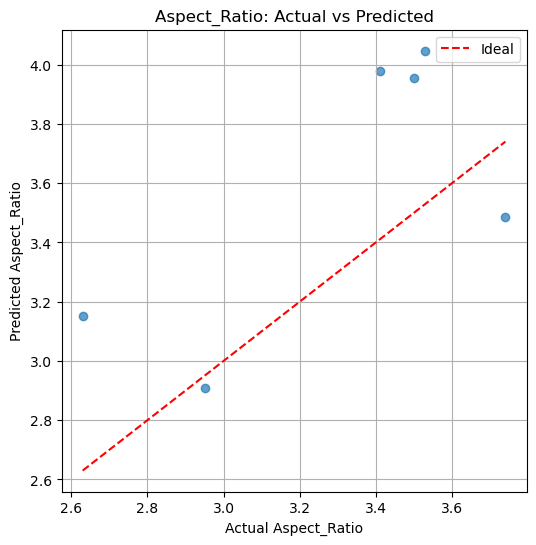

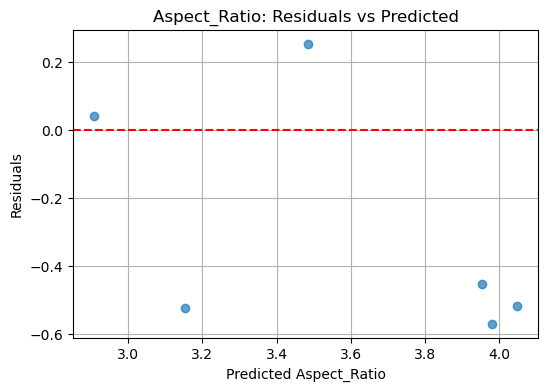


Dilution_Percent Metrics:
  MAE: 3.024
  MSE: 20.250
  RMSE: 4.500
  R²: 0.456


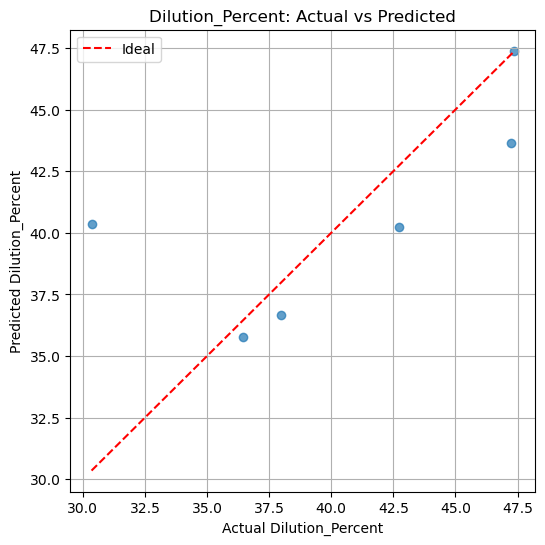

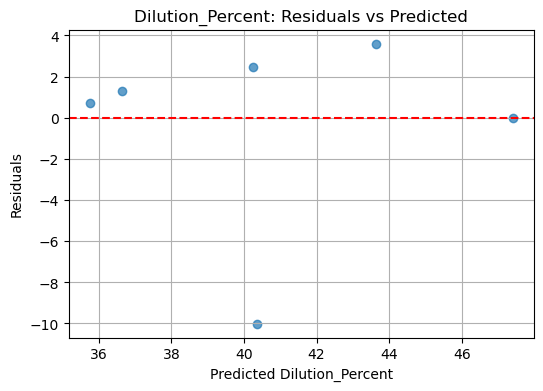


PCE_Percent Metrics:
  MAE: 5.856
  MSE: 37.815
  RMSE: 6.149
  R²: 0.574


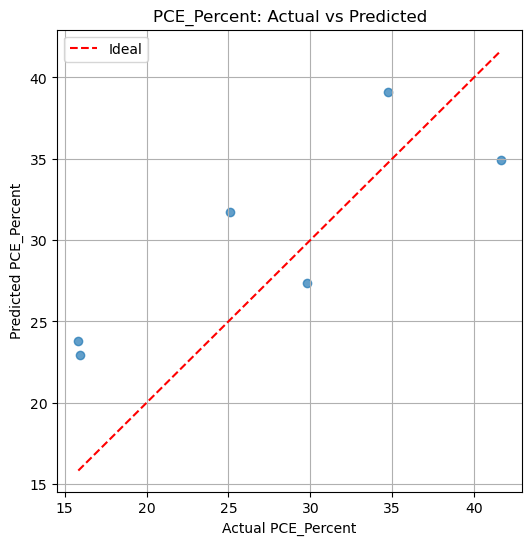

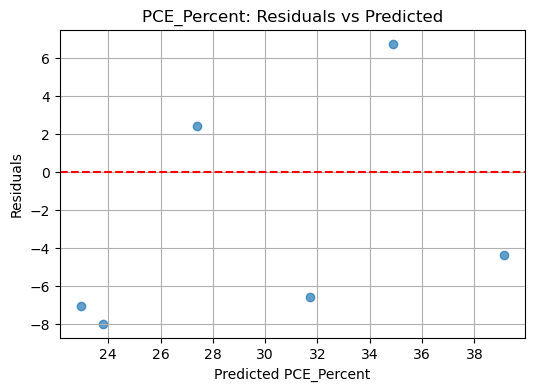

In [6]:
# Predict on test set
Y_pred = model.predict([X_num_test, X_img_test])

for i, target in enumerate(targets):
    mae = mean_absolute_error(Y_test[:, i], Y_pred[:, i])
    mse = mean_squared_error(Y_test[:, i], Y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test[:, i], Y_pred[:, i])
    print(f"\n{target} Metrics:")
    print(f"  MAE: {mae:.3f}")
    print(f"  MSE: {mse:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²: {r2:.3f}")

    # Actual vs Predicted plot
    plt.figure(figsize=(6,6))
    plt.scatter(Y_test[:, i], Y_pred[:, i], alpha=0.7)
    plt.plot([Y_test[:, i].min(), Y_test[:, i].max()],
             [Y_test[:, i].min(), Y_test[:, i].max()],
             'r--', label='Ideal')
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target}")
    plt.title(f"{target}: Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Residual plot
    residuals = Y_test[:, i] - Y_pred[:, i]
    plt.figure(figsize=(6,4))
    plt.scatter(Y_pred[:, i], residuals, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel(f"Predicted {target}")
    plt.ylabel("Residuals")
    plt.title(f"{target}: Residuals vs Predicted")
    plt.grid(True)
    plt.show()


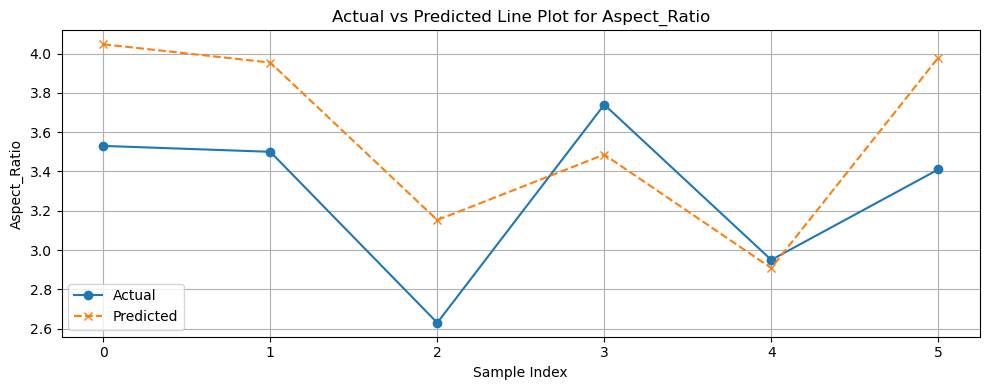

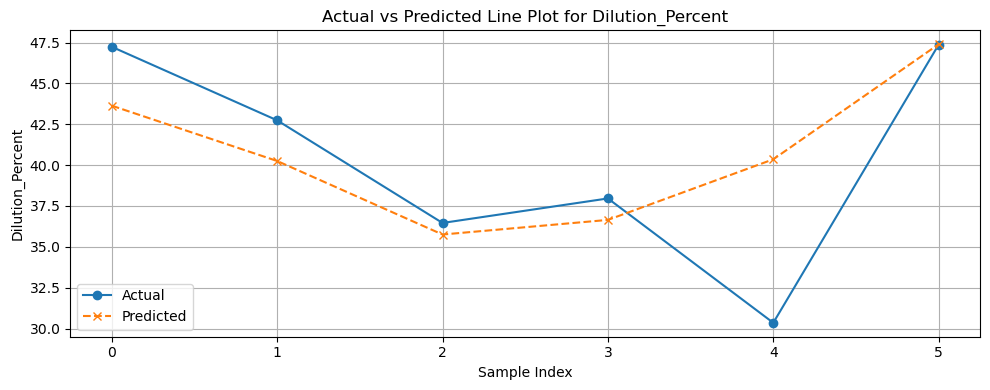

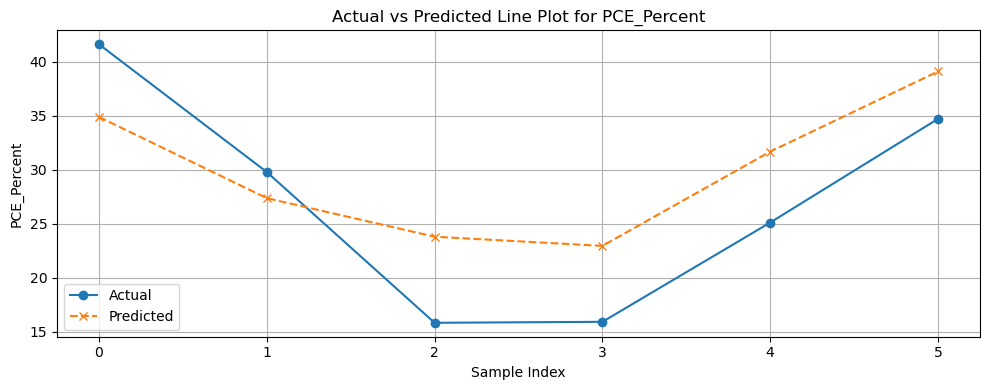

In [7]:
for i, target in enumerate(targets):
    plt.figure(figsize=(10, 4))
    plt.plot(Y_test[:, i], label='Actual', linestyle='-', marker='o')
    plt.plot(Y_pred[:, i], label='Predicted', linestyle='--', marker='x')
    plt.xlabel('Sample Index')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted Line Plot for {target}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


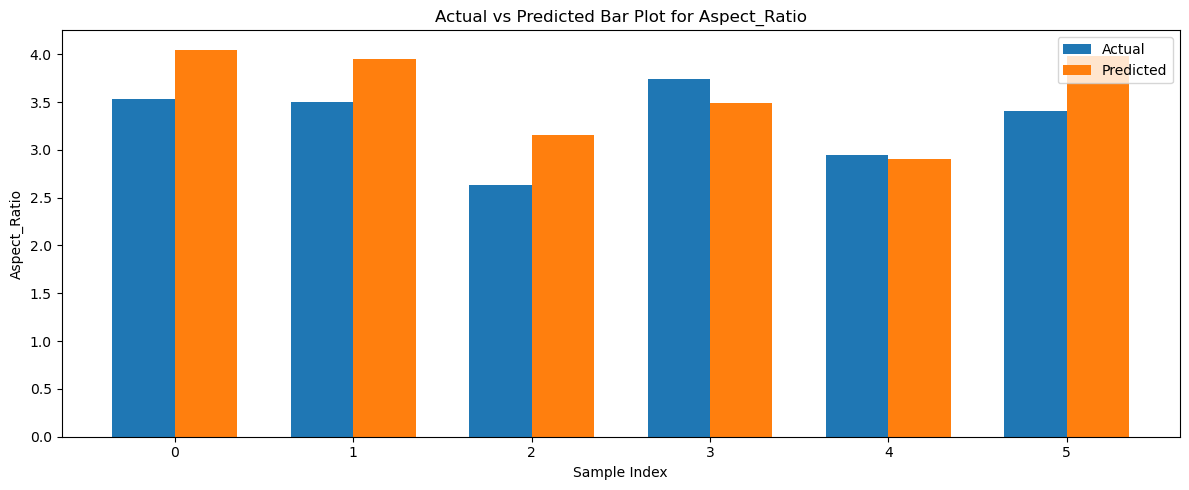

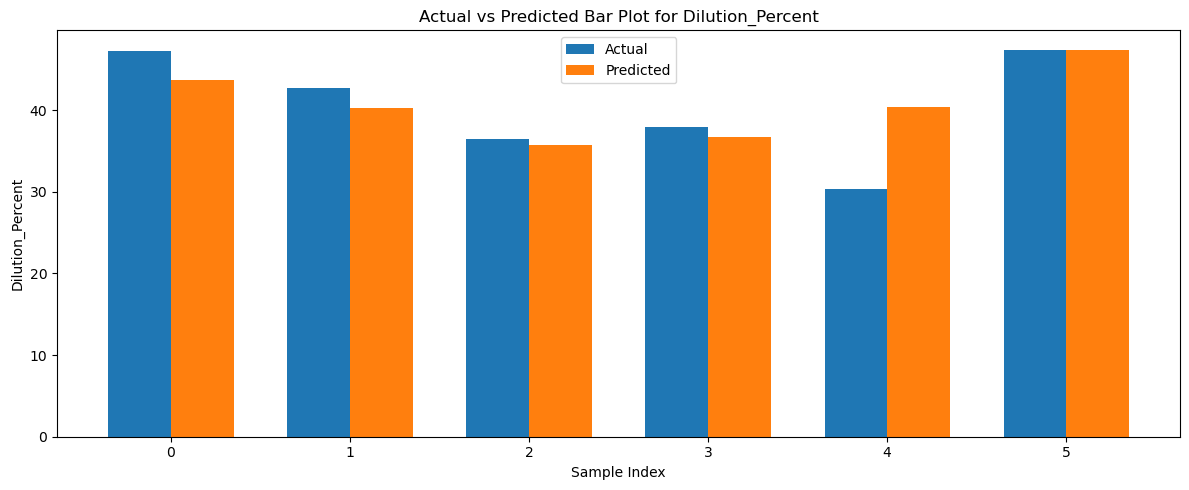

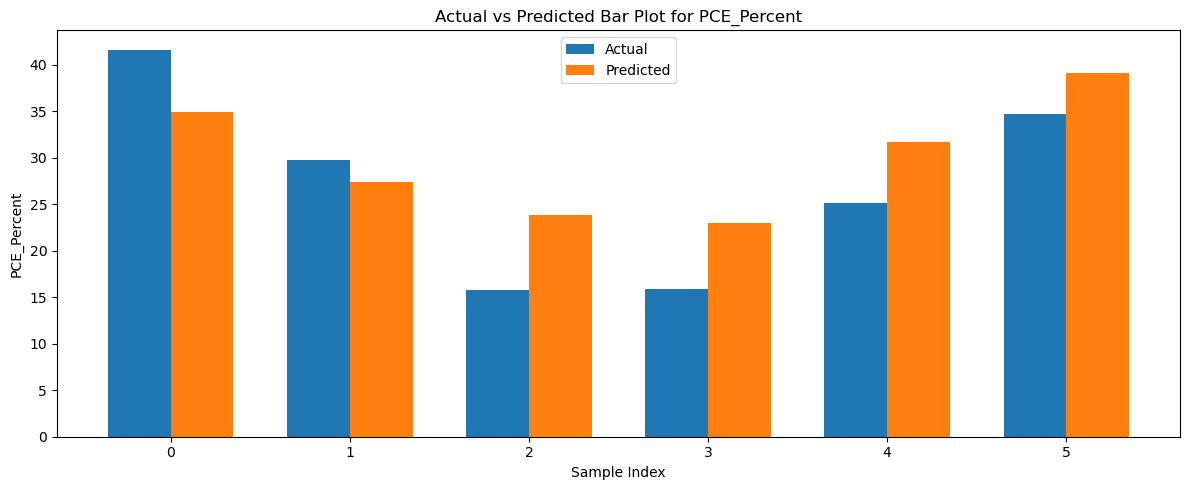

In [8]:
for i, target in enumerate(targets):
    x = np.arange(len(Y_test[:, i]))
    width = 0.35

    plt.figure(figsize=(12, 5))
    plt.bar(x - width/2, Y_test[:, i], width, label='Actual')
    plt.bar(x + width/2, Y_pred[:, i], width, label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted Bar Plot for {target}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [9]:
mse_total = np.mean((Y_test - Y_pred)**2)
print(f"Overall MSE (orig units): {mse_total:.4f}")

Overall MSE (orig units): 19.4180


In [11]:
# -----------------------------
# 12. Save model
# -----------------------------
model.save("early_fusion_resnet50.keras")